# Bank Customer Churn Prediction

This project is to predict the customer churn.

**Customer Churn**: the percentage of customers that stopped using your company's product or service during a certain time frame

Here, our goal is to find out what are the crucial factors that turn the customers down and makes them leave the business.

Here is the table schema and the definition of each features

|**Column**|**Description**|
|----------|---------------|
|**RowNumber**|Row number|
|**CustomerId**|Unique customer ID|
|**Surname**|Surname|
|**CreditScore**|Customer credit score|
|**Geography**|Customer's location: *France*, *Germany*, and *Spain*|
|**Gender**|Customer's gender: *Male* and *Female*|
|**Age**|Customer's age|
|**Tenure**|Number of years that the customer has been client of the bank|
|**Balance**|Customer's bank account balance|
|**NumOfProducts**|The number of products that the customer has purchased through the bank|
|**HasCrCard**|Whether a customer has a credit card or not|
|**IsActiveMember**|active customers are less likely to leave the bank|
|**EstimatedSalary**|Estimated salary of a customer|
|**Exited**|Whether a customer left the bank or not|
|**Complain**|Whether a customer complained or not|
|**SatisfactionScore**|Score provided by the customer for their complaint resolution|
|**CardType**|Type of card hold by the customer|
|**PointsEarned**|The points earned by the customer for using credit card|

Even before looking at the data, we already get some insights.
1. Columns like `RowNumber`, `CustomerID`, and `Surname` are most likely don't affect the target variable, `Exited`.
2. `SatisfactionScore` seems to be dependant on `Complain` column, because it's a score from the resolution provided ***after*** the complaint.

## Points to check before analysis

type of problem: **Binary Classification**


In [1]:
# Import the pacakges
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [22]:
# Collection of the methods that can be reused
# Let's check for null values in a visual way
def calculate_fillrate(df):
    total_records = len(df)
    fill_rate = df.notna().mean() * 100
    num_of_notna = df.notna().sum()
    
    fill_rate_df = pd.DataFrame({
        'columns': df.columns,
        'fill_rate': fill_rate,
        'num_of_notna': num_of_notna,
        'total_records': total_records
    }).reset_index(drop=True)
    
    return fill_rate_df


def plot_categorical_pie_charts(df, nrows=None, ncols=None, title=None):
    
    # Check for the title
    if not title:
        title = "Categorical Columns Distribution"
    # Select categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # If nrows and ncols are not provided, default to a single column layout
    if nrows is None or ncols is None:
        nrows = len(categorical_cols)
        ncols = 1
    
    # Create subplots with the specified number of rows and columns
    fig = make_subplots(
        rows=nrows, 
        cols=ncols, 
        subplot_titles=categorical_cols[:nrows*ncols], 
        specs=[[{'type': 'domain'}] * ncols] * nrows
    )
    
    # Add pie charts to subplots
    for i, col in enumerate(categorical_cols):
        row = (i // ncols) + 1
        col_pos = (i % ncols) + 1
        value_counts = df[col].value_counts()
        fig.add_trace(
            go.Pie(labels=value_counts.index, values=value_counts.values, name=col),
            row=row, col=col_pos
        )
        if i >= nrows * ncols - 1:
            break

    # Update layout
    fig.update_layout(height=300 * nrows, title_text=title, showlegend=False)
    fig.show()


def numerical_columns_only(df):
    
    # Select only numerical columns
    numerical_df = df.select_dtypes(include='number')
    
    return numerical_df

## Step 0.) Initial look at the data and data cleansing

* There are `10002` rows in the dataset.
* `CreditScore`, `Age`, `Tenure`, `Balance`, and `NumOfProducts` are continuous features.
* `Surname`, `Geography`, and `Gender` are categorical features.
    * For `Surname`, there are 2932 unique surnames.
    * For `Geography` there are 3 countires: *France*, *Germany*, and *Spain*.
    * For `Card Type` there are 4 types: *DIAMOND*, *GOLD*, *SILVER*, *PLATINUM*
* It's a VERY CLEAN data with no null values.

In [3]:
# Import the data
data = pd.read_csv("data/Customer-Churn-Records.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [4]:
# Basic summary statistics of the data
data.describe(include='all')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIAMOND,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2507,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,NaN,606.515100
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,NaN,225.924839
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,NaN,119.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,NaN,410.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,NaN,605.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,NaN,801.000000


In [5]:
# What's the number of records?
data.shape[0]

10000

In [6]:
# Take a look at the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

In [7]:
# Unique values for each categorical columns

def distinct_values_for_non_numerical(df):
    # select categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # Get the unique values
    unique_values = {col: df[col].unique() for col in categorical_cols}

    for col, values in unique_values.items():
        print(f"Unique values in column '{col}': {values}")
    
distinct_values_for_non_numerical(data)

Unique values in column 'Surname': ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
Unique values in column 'Geography': ['France' 'Spain' 'Germany']
Unique values in column 'Gender': ['Female' 'Male']
Unique values in column 'Card Type': ['DIAMOND' 'GOLD' 'SILVER' 'PLATINUM']


In [8]:
# Let's check for null values in a visual way
def calculate_fillrate(df):
    total_records = len(df)
    fill_rate = df.notna().mean() * 100
    num_of_notna = df.notna().sum()
    
    fill_rate_df = pd.DataFrame({
        'columns': df.columns,
        'fill_rate': fill_rate,
        'num_of_notna': num_of_notna,
        'total_records': total_records
    }).reset_index(drop=True)
    
    return fill_rate_df

fill_rate = calculate_fillrate(data)

fill_rate

,columns,fill_rate,num_of_notna,total_records
0,RowNumber,100.0,10000,10000
1,CustomerId,100.0,10000,10000
2,Surname,100.0,10000,10000
3,CreditScore,100.0,10000,10000
4,Geography,100.0,10000,10000
5,Gender,100.0,10000,10000
6,Age,100.0,10000,10000
7,Tenure,100.0,10000,10000
8,Balance,100.0,10000,10000
9,NumOfProducts,100.0,10000,10000


### Data Cleansing: Drop Irrelevant columns and  records with null values

In [9]:
# Let's drop RowNumber, CustomerId, and Surname columns.
drop_irrelevant_cols = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Cleanse the data by dropping the Null values
drop_null_data = drop_irrelevant_cols.dropna()

calculate_fillrate(drop_null_data)

,columns,fill_rate,num_of_notna,total_records
0,CreditScore,100.0,10000,10000
1,Geography,100.0,10000,10000
2,Gender,100.0,10000,10000
3,Age,100.0,10000,10000
4,Tenure,100.0,10000,10000
5,Balance,100.0,10000,10000
6,NumOfProducts,100.0,10000,10000
7,HasCrCard,100.0,10000,10000
8,IsActiveMember,100.0,10000,10000
9,EstimatedSalary,100.0,10000,10000


## Step 1.) Exploratory Data Analysis

Here, we are exploring the histogram of continuous variables to see if there are any skewness, and need of transformation.

Moreover, we are going to plot barcharts for the categorical variables, except the `Surname`, so see the ratio of each categories.


In [10]:
drop_null_data.describe(include='all')

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
count,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000.000000
unique,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
top,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIAMOND,NaN
freq,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2507,NaN
mean,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,NaN,606.515100
std,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,NaN,225.924839
min,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,NaN,119.000000
25%,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,NaN,410.000000
50%,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,NaN,605.000000
75%,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,NaN,801.000000


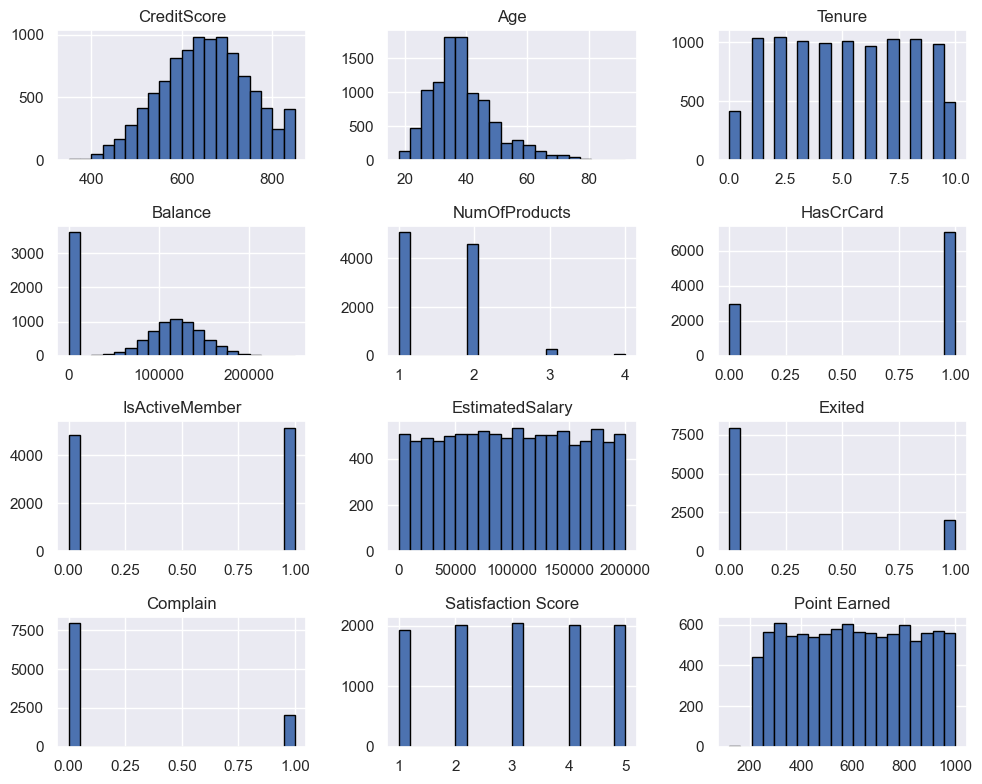

In [11]:
# Histogram of all the continous variables.
drop_null_data.hist(figsize=(10, 8), bins=20, edgecolor='black')

plt.tight_layout()
plt.show()

In [16]:
# Let's see the pie charts for all the categorical columns and the binary columns as well
binary_to_categorical = drop_null_data.copy()
columns_to_convert = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited', 'Complain']
binary_to_categorical[columns_to_convert] = binary_to_categorical[columns_to_convert].astype('category')

plot_categorical_pie_charts(binary_to_categorical, 3, 3, "Overall Ratio")

In [64]:
# median values
numerical_data = drop_ids.drop(columns=['HasCrCard', 'Surname', 'Geography', 'Gender', 'IsActiveMember', 'Exited'])

numerical_data.median()

CreditScore           652.00
Age                    37.00
Tenure                  5.00
Balance             97173.29
NumOfProducts           1.00
EstimatedSalary    100218.21
dtype: float64


### Analysis
1. `CreditScore` is slightly skewed to left with mean of 650.53, stand deviation of 96.63. median value for this column is 652.00
2. `Balance` has a lot of 0s. Therefore, the shape of distribution is weird. We need to transform the column.
3. We see that the `Geography` column has 50% of *France*. We should be aware of this when creating training set and testing set so that we can avoid the sampling error.
4. Intuitively, we already know that the `Complain` column would be highly correlated to our target column, `Exited`. We see that the percentage for those who complained is **exactly the same for those who exited**.
    1. Further Analysis shows that out of those who exited, ***99% of customers has compained***
5. Unlike the total sample shows 50.8% and 45.9%, and those who did not exited showing 46.2% and 53.3% for `NumOfProducts = 1` and `NumOfProducts = 2`, respectively, those who exited has the percentage of 69.1% and 17.1% for `NumOfProducts = 1` and `NumOfProducts = 2`, respectively. From the data, we can conclude that there is a higher probability of customers exiting, when they've only purchased one product through the bank.
6. There is a higher chance of customers exiting when the customers are inactive.


### ToDo
* Boxplot for each types for continuous variables.

### Pie Chart for Categorical / Binary Variables!

From the section below, we plot the pie charts to see the ratio of the features

In [15]:
# Split the data into two: exited or not.
binary_to_categorical_exited = binary_to_categorical[binary_to_categorical['Exited'] == 1]
binary_to_categorical_not_exited = binary_to_categorical[binary_to_categorical['Exited'] == 0]

In [17]:
plot_categorical_pie_charts(binary_to_categorical_exited, 3, 3, "Ratio for Exited = 1")

In [19]:
plot_categorical_pie_charts(binary_to_categorical_not_exited, 3, 3, "Ratio for Exited = 0")

<Axes: >

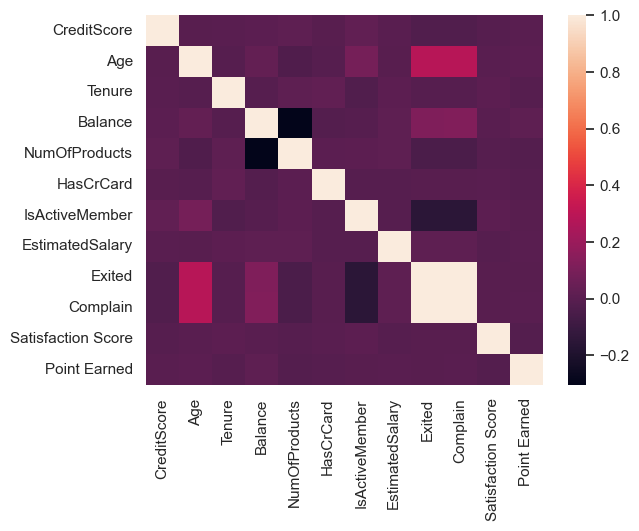

In [24]:
# Let's get the see the correlation of the columns for the target: Exited
numerical_columns_df = numerical_columns_only(drop_null_data)

sns.heatmap(numerical_columns_df.corr())